# Hyperparameter exploration

We are now going to model the circles dataset again and see how, not only the kernel, but all hyperparameters, affect our outcome.

## Dataset

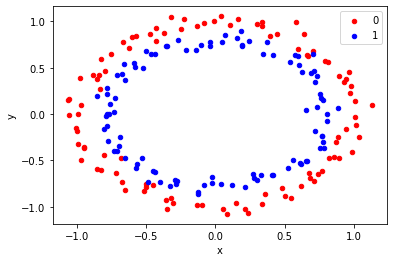

In [23]:
import pandas as pd
import numpy as np
from sklearn.datasets import make_circles
import matplotlib.pyplot as plt

X, y = make_circles(n_samples=200, noise=0.05)

df = pd.DataFrame(dict(x=X[:,0], y=X[:,1], label=y))
colors = {0:'red', 1:'blue'}

fig, ax = plt.subplots()
grouped = df.groupby('label')
for key, group in grouped:
    group.plot(ax=ax, kind='scatter', x='x', y='y', label=key, color=colors[key])
plt.show()

## MLP

Let's start by creating our training and test sets again:

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

Now, let's run the same model with linear kernel, as before:

In [5]:
from tensorflow.keras.models import Sequential
from keras.layers.core import Dense, Activation

input_dim = X_train.shape[1]
output_dim = 1

model = Sequential()
model.add(Dense(50,input_dim=input_dim))
model.add(Activation('linear'))
model.add(Dense(50))
model.add(Activation('linear'))
model.add(Dense(output_dim))
model.add(Activation('sigmoid'))
model.compile(optimizer='sgd',loss='binary_crossentropy',metrics=['accuracy'])

model.summary()

model.fit(X_train,y_train,epochs=10)


prediction_prob = model.predict(X_test)
prediction_class = np.argmax(prediction_prob,axis=1)

print('Accuracy:', accuracy_score(y_test,prediction_class))
print('AUC:',roc_auc_score(y_test,prediction_prob))

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 50)                150       
_________________________________________________________________
activation_6 (Activation)    (None, 50)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 50)                2550      
_________________________________________________________________
activation_7 (Activation)    (None, 50)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 51        
_________________________________________________________________
activation_8 (Activation)    (None, 1)                 0         
Total params: 2,751
Trainable params: 2,751
Non-trainable params: 0
____________________________________________________

That's not very good is it? We knew this was coming from playing around in the TensorFlow playground and our earlier experiments. We can also visualise the result:

In [15]:
prediction_prob.argmax(axis=1)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int64)

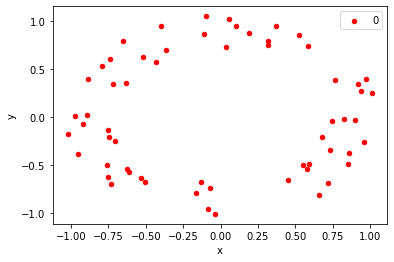

In [17]:
df = pd.DataFrame(dict(x=X_test[:,0], y=X_test[:,1], label=prediction_class))
colors = {0:'red', 1:'blue'}

fig, ax = plt.subplots()
grouped = df.groupby('label')
for key, group in grouped:
    group.plot(ax=ax, kind='scatter', x='x', y='y', label=key, color=colors[key])
plt.show()

The linear kernel is clearly not suitable. Let's try something different:

## Different hyperparameters

Let's explore a range of hyperparameters. More specifically, we will focus on:
- Activation function
- Number of neurons in a hidden layer
- Number of layers
- Learning rate
- Number of epochs

In [19]:
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.optimizers import Adam

def nn_grid_search(parameters,n_folds,X_train,y_train):
    
    # First, create the neural network model
    def nn_model(kernel,no_neurons,learning_rate,epochs,no_layers):
        model = Sequential()
        model.add(Dense(no_neurons,input_dim=X_train.shape[1]))
        model.add(Activation(kernel))

        # Extra hidden layers
        for _ in range(0,no_layers):
            model.add(Dense(no_neurons))
            model.add(Activation(kernel))

        # Output
        model.add(Dense(1))
        model.add(Activation('sigmoid'))
        model.compile(optimizer=Adam(lr=learning_rate),loss='binary_crossentropy',metrics=['accuracy'])
        
        return model
    
    # Next, apply the grid search using the parameters for your neural network model
    grid_search = GridSearchCV(KerasClassifier(nn_model), parameters, cv=n_folds,scoring='roc_auc')
       
    # Fit the data
    grid_search.fit(X_train, y_train.ravel())
    
    means = grid_search.cv_results_['mean_test_score']
    stds = grid_search.cv_results_['std_test_score']
    params = grid_search.cv_results_['params']
    
    return means, stds, params

Next, we run the grid search:

In [21]:
import warnings
warnings.simplefilter('ignore')

In [22]:
parameters = {'no_neurons':[10,20],'kernel':['relu','linear'],'no_layers':[1,2],'learning_rate':[0.1,0.01,0.001],'epochs':[5,10],'verbose':[0]} 
n_folds = 5

means, stds, params = nn_grid_search(parameters,n_folds,X_train,y_train)

print('Mean AUC (+/- standard deviation), for parameters')
for mean, std, param_o in zip(means, stds, params):
    print("%0.3f (+/- %0.03f) for %r"
          % (mean, std, param_o))

Mean AUC (+/- standard deviation), for parameters
0.562 (+/- 0.143) for {'epochs': 5, 'kernel': 'relu', 'learning_rate': 0.1, 'no_layers': 1, 'no_neurons': 10, 'verbose': 0}
0.593 (+/- 0.110) for {'epochs': 5, 'kernel': 'relu', 'learning_rate': 0.1, 'no_layers': 1, 'no_neurons': 20, 'verbose': 0}
0.517 (+/- 0.088) for {'epochs': 5, 'kernel': 'relu', 'learning_rate': 0.1, 'no_layers': 2, 'no_neurons': 10, 'verbose': 0}
0.608 (+/- 0.119) for {'epochs': 5, 'kernel': 'relu', 'learning_rate': 0.1, 'no_layers': 2, 'no_neurons': 20, 'verbose': 0}
0.506 (+/- 0.054) for {'epochs': 5, 'kernel': 'relu', 'learning_rate': 0.01, 'no_layers': 1, 'no_neurons': 10, 'verbose': 0}
0.562 (+/- 0.082) for {'epochs': 5, 'kernel': 'relu', 'learning_rate': 0.01, 'no_layers': 1, 'no_neurons': 20, 'verbose': 0}
0.558 (+/- 0.066) for {'epochs': 5, 'kernel': 'relu', 'learning_rate': 0.01, 'no_layers': 2, 'no_neurons': 10, 'verbose': 0}
0.548 (+/- 0.144) for {'epochs': 5, 'kernel': 'relu', 'learning_rate': 0.01, 'n

Again, we see that the ReLU kernel clearly outperforms the linear one. Besides, we notice that the influence of epochs is apparent: results appear to be much more homogeneous over the various learning rates. 

The highest learning rate (0.1), however, tends to result in the highest AUC. The structure of the network (number of layers and number of neurons) seems to have little impact on the final results, although only one layer gets the best results.

This shows how effective hyperparameter search can be in order to finetune your neural network.